In [1]:
# Multinomial Logistic Regression for Wildfire cause "NWCG_CAUSE_CLASSIFICATION"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
# For nicer printing
pd.set_option("display.max_columns", 50)

In [2]:
df = pd.read_csv("wildfires_greather_than_100acres_with_temperature.xls")

#Define Target and predictor columns
df = df.dropna().copy()
# Define target and predictors
year_col   = "FIRE_YEAR"      # year of fire
target_col = "NWCG_CAUSE_CLASSIFICATION"      # Class of Cause

feature_cols = [
    "LATITUDE",
    "LONGITUDE",
    "DISCOVERY_DOY",  # day of year (numeric)
    "TMAX",           # max temperature
]
train_mask = (df[year_col] >= 1992) & (df[year_col] <= 2015)
test_mask  = (df[year_col] >= 2016) & (df[year_col] <= 2020)
train_df = df.loc[train_mask].copy()
test_df  = df.loc[test_mask].copy()

In [3]:
all_cols = train_df.columns.tolist()

# Heuristic: treat numeric vs object
numeric_cols = train_df[all_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_df[all_cols].select_dtypes(include=["object", "category"]).columns.tolist()

# Remove geographic/time columns from categorical if you prefer numeric
# For example latitude/longitude are numeric already; ensure they are included
print("Numeric predictors:", numeric_cols)
print("Categorical predictors:", cat_cols)
predictor_cols = numeric_cols + cat_cols

Numeric predictors: ['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'TMAX']
Categorical predictors: ['DISCOVERY_DATE', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'OWNER_DESCR', 'FIRE_SIZE_CLASS', 'STATE', 'DATE']


In [4]:
# Train = 1992–2015, Test = 2016–2020
train_df = df.loc[(df[year_col] >= 1992) & (df[year_col] <= 2015)].copy()
test_df  = df.loc[(df[year_col] >= 2016) & (df[year_col] <= 2020)].copy()

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Train shape: (10447, 13)
Test  shape: (2375, 13)


In [5]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [6]:
logreg = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=5000,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", logreg)
])

# Hyperparameter search
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
}

gs = GridSearchCV(
    pipe,
    param_grid,
    scoring="accuracy",
    cv=5,              # ← simple k-fold
    n_jobs=-1,
    verbose=1
)

# Fit model
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best CV score:", gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'clf__C': 10, 'clf__penalty': 'l2'}
Best CV score: 0.6782820928032689


In [7]:
best_model = gs.best_estimator_

# Fit best model on full training set (GridSearchCV already refits by default)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)  # shape (n_samples, n_classes)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=best_model.named_steps["clf"].classes_)

print("\nTest accuracy:", acc)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Test accuracy: 0.5574736842105263

Confusion matrix:
 [[746   0 429]
 [ 79   1 135]
 [408   0 577]]

Classification report:
                                          precision    recall  f1-score   support

                                  Human       0.61      0.63      0.62      1175
Missing data/not specified/undetermined       1.00      0.00      0.01       215
                                Natural       0.51      0.59      0.54       985

                               accuracy                           0.56      2375
                              macro avg       0.70      0.41      0.39      2375
                           weighted avg       0.60      0.56      0.53      2375



In [8]:
# Binarize labels to compute ROC AUC in a one-vs-rest fashion
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))
y_test_enc = le.transform(y_test)
classes = le.classes_
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(classes)))

# predict_proba order matches classifier classes; map them to label-encoder order
# the gs pipeline's classifier classes_ may be in different order; we need to reorder columns
clf_classes = best_model.named_steps["clf"].classes_
# map column indices: clf_classes -> index in le.classes_
col_order = [np.where(classes == c)[0][0] for c in clf_classes]
# reorder y_proba columns to match label_binarize ordering
y_proba_reordered = np.zeros_like(y_proba)
for i, col_idx in enumerate(col_order):
    y_proba_reordered[:, col_idx] = y_proba[:, i]

# Compute per-class ROC AUC (OvR)
per_class_auc = {}
for i, cls in enumerate(classes):
    try:
        auc = roc_auc_score(y_test_bin[:, i], y_proba_reordered[:, i])
    except ValueError:
        auc = np.nan
    per_class_auc[cls] = auc

# Macro and weighted AUC (sklearn supports multi_class='ovr' with label-binarized arrays)
try:
    macro_auc = roc_auc_score(y_test_bin, y_proba_reordered, average="macro", multi_class="ovo")
    weighted_auc = roc_auc_score(y_test_bin, y_proba_reordered, average="weighted", multi_class="ovo")
except Exception:
    macro_auc = np.nan
    weighted_auc = np.nan

print("\nPer-class ROC-AUC (OvR):")
for cls, a in per_class_auc.items():
    print(f"  {cls}: {a:.3f}")

print(f"\nMacro AUC (ovo): {macro_auc:.3f}")
print(f"Weighted AUC (ovo): {weighted_auc:.3f}")


Per-class ROC-AUC (OvR):
  Human: 0.678
  Missing data/not specified/undetermined: 0.609
  Natural: 0.653

Macro AUC (ovo): 0.647
Weighted AUC (ovo): 0.661


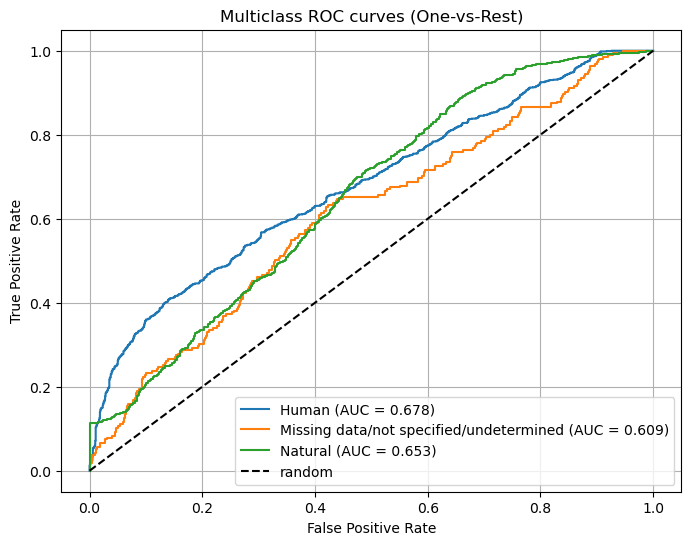

In [9]:
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    if np.isnan(per_class_auc[cls]):
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_reordered[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {per_class_auc[cls]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()